# Part 02 - Exploratory Data Analysis
--------

## Importing data
--------
We import all the csv files for data analysis.

We specify which data type to use in order to save on memory usage.
If not specified, the default data type used will be int64. For many
of the features, we can use int8, which may cut the memory usage down
to 1/8.

In [1]:
# initializing
%matplotlib inline

# styling plots
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.figsize'] = [12, 6]

path = 'data/'

In [2]:
df_aisles = pd.read_csv(path + 'aisles.csv')
df_departments = pd.read_csv(path + 'departments.csv')
df_data = pd.read_csv(path + 'order_products__prior.csv', dtype={
    'order_id': np.int32,
    'product_id': np.int32,
    'add_to_cart_order': np.int16,
    'reordered': np.int8,
})
df_train_target = pd.read_csv(path + 'order_products__train.csv')
df_orders = pd.read_csv(path + 'orders.csv', dtype={
    'order_id': np.int32,
    'user_id': np.int32,
    'order_number': np.int8,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
})
df_products = pd.read_csv(path + 'products.csv')
df_sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [3]:
df_orders = df_orders.set_index('order_id')
df_products = df_products.set_index('product_id')

## Split the data into two groups

In [4]:
order_id_to_user_id = df_orders.user_id

In [5]:
users_train = df_orders.loc[df_orders.eval_set == 'train', 'user_id']
users_test = df_orders.loc[df_orders.eval_set == 'test', 'user_id']

In [6]:
# expand the main dataframe
df_data['user_id'] = df_data.order_id.map(df_orders.user_id)
df_data['order_number'] = df_data.order_id.map(df_orders.order_number)
df_data['order_dow'] = df_data.order_id.map(df_orders.order_dow)
df_data['order_hour_of_day'] = df_data.order_id.map(df_orders.order_hour_of_day)
df_data['days_since_prior_order'] = df_data.order_id.map(df_orders.days_since_prior_order)

In [7]:
df_train = df_data.loc[df_data.user_id.isin(users_train)]
df_test = df_data.loc[df_data.user_id.isin(users_test)]

In [8]:
print('# of orders in all prior orders: {:,}'.format(df_data.shape[0]))
print('# of orders in all prior orders of training data: {:,}'.format(df_train.shape[0]))
print('# of orders in all prior orders of test data: {:,}'.format(df_test.shape[0]))

# of orders in all prior orders: 32,434,489
# of orders in all prior orders of training data: 20,641,991
# of orders in all prior orders of test data: 11,792,498


In [9]:
# delete to free up memory
try:
    del df_data
except:
    pass

In [10]:
# just a helper function for reordering columns
# takes a list of columns to put at the very front
def columns_to_front(df, columns):
    ordered_columns = columns + [column for column in df.columns if column not in columns]
    return df[ordered_columns]

In [11]:
# reordering columns for to get a better view
df_train = columns_to_front(df_train, ['user_id', 'order_number', 'order_id', 'add_to_cart_order'])\
                     .sort_values(by=['user_id', 'order_number', 'add_to_cart_order'])

In [12]:
df_train.head(10)

,user_id,order_number,order_id,add_to_cart_order,product_id,reordered,order_dow,order_hour_of_day,days_since_prior_order
24076664,1,1,2539329,1,196,0,2,8,NaN
24076665,1,1,2539329,2,14084,0,2,8,NaN
24076666,1,1,2539329,3,12427,0,2,8,NaN
24076667,1,1,2539329,4,26088,0,2,8,NaN
24076668,1,1,2539329,5,26405,0,2,8,NaN
22742744,1,2,2398795,1,196,1,3,7,15.0
22742745,1,2,2398795,2,10258,0,3,7,15.0
22742746,1,2,2398795,3,12427,1,3,7,15.0
22742747,1,2,2398795,4,13176,0,3,7,15.0
22742748,1,2,2398795,5,26088,1,3,7,15.0


In [13]:
# just curious which items are the ones provided in the sample submission file
sample_products = []
for product_list in df_sample_submission.products.unique():
    temp = product_list.split(sep=' ')
    for product in temp:
        sample_products.append(int(product))

df_products[df_products.index.isin(sample_products)]

,product_name,aisle_id,department_id
product_id,,,
29259,Baby Bananas,24,4
39276,Bananas,24,4


## How are aisles among departments?

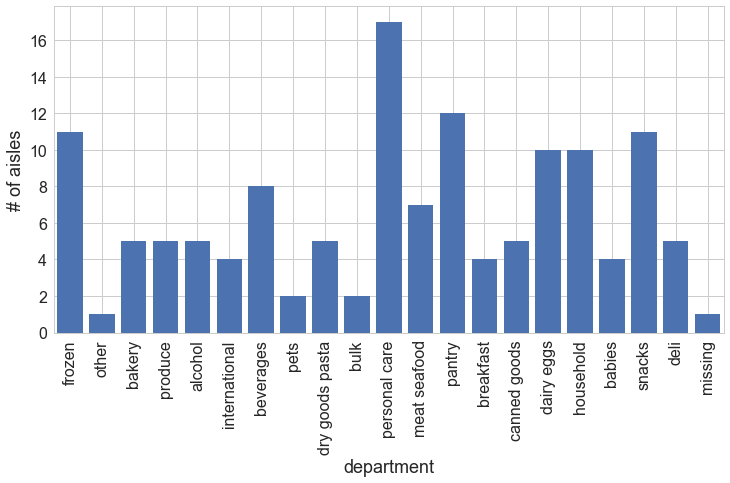

In [14]:
df = df_products.reset_index().groupby('department_id').agg(lambda x: x.nunique())
plt.bar(df.index, df.aisle_id)
plt.xticks(df_departments.department_id, df_departments.department, rotation=90)
plt.xlim(df_departments.department_id.min() - 1/2, df_departments.department_id.max() + 1/2)
plt.xlabel('department')
plt.ylabel('# of aisles')

## How are products distributed among departments?

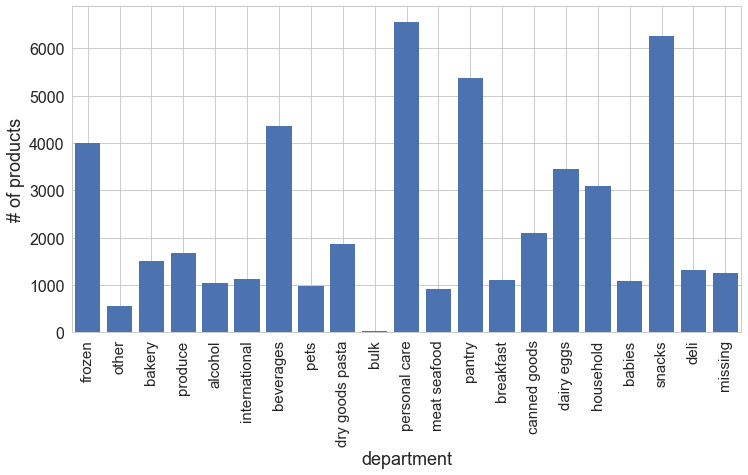

In [15]:
plt.bar(df.index, df.product_id)
plt.xticks(df_departments.department_id, df_departments.department, rotation=90, size=15)
plt.xlim(df_departments.department_id.min() - 1/2, df_departments.department_id.max() + 1/2)
plt.xlabel('department')
plt.ylabel('# of products')

## How often do people place an order again since the previous order?
--------
We see that there are noticable spikes at 7 and 30.

The spike at 7 probably means that there are many people ordering
things on weekly basis. This rather makes sense when shopping for
groceries. Note that there are also minor bumps at 14, 21, and 28.

The spike at 30 may mean that people are ordering things on monthly
basis. However, noting that the value is capped at 30, and the spike
being rather huge, this probably means that ``days_since_prior_order``
of value 30 includes all values above 30 in the real life data.

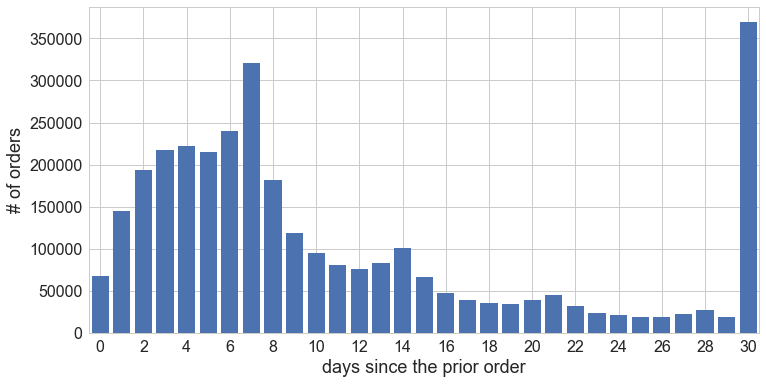

In [16]:
# this excludes all first orders
plt.hist(df_orders.loc[df_orders.days_since_prior_order.notnull(), 'days_since_prior_order'],
         bins=np.arange(df_orders.days_since_prior_order.min() - 1/2,
                        df_orders.days_since_prior_order.max() + 1/2 + 1),
         rwidth=0.8)
plt.xlabel('days since the prior order')
plt.ylabel('# of orders')
plt.xticks(np.arange(df_orders.days_since_prior_order.min(), df_orders.days_since_prior_order.max() + 1, 2));
plt.xlim(df_orders.days_since_prior_order.min() - 1/2, df_orders.days_since_prior_order.max() + 1/2);

## What day of the week do people order the most?
--------
Days of the week marked by 0 and 1 seem to have significantly higher
number of orders compared to the rest. We may naively assume that
they constitute weekends, i.e. Saturdays and Sundays.

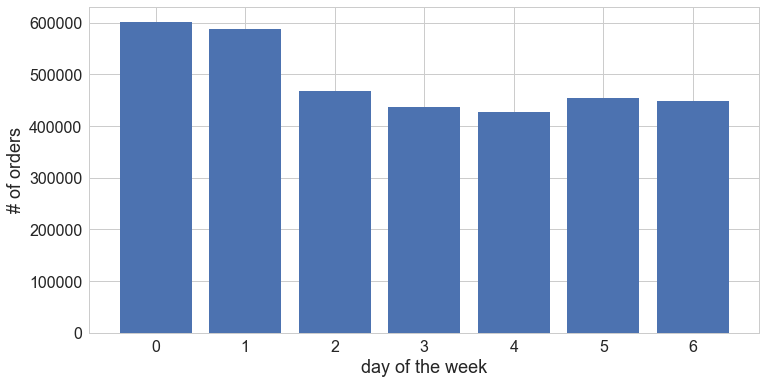

In [17]:
plt.hist(df_orders.order_dow,
         bins=np.arange(df_orders.order_dow.min() - 1/2,
                        df_orders.order_dow.max() + 1/2 + 1),
         rwidth=0.8)
plt.xlabel('day of the week')
plt.ylabel('# of orders')

## How are the number of prior orders distributed?
--------
This shows how many times users have placed an order on the site.

Note that the least number of orders placed by a user from the data
is 3 and the most number of orders placed by a user is 99 (excluding
the last orders). As there is a large spike at the end, we may assume
either that users with 99 prior orders include all users who have
purchased more than 99 times on the site.

This may be due to either the site tracking only last 100 orders or
its just the way the data provider decided to give us.

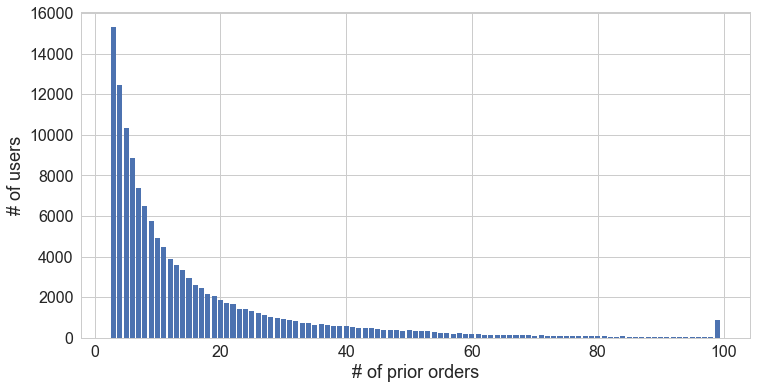

In [18]:
df = df_train.groupby('user_id').agg({'order_number': 'nunique'})
plt.hist(df.order_number,
         bins=np.arange(df.order_number.min() - 1/2,
                        df.order_number.max() + 1/2 + 1),
         rwidth=0.8)
plt.xlabel('# of prior orders')
plt.ylabel('# of users')

In [19]:
# accessing the first element via [0] is needed since min function returns a series
print('least number of prior orders: {}'.format(df.min()[0]))
print('most number of prior orders: {}'.format(df.max()[0]))

least number of prior orders: 3
most number of prior orders: 99


There may be several ways to compute reorder probability.

## Number of prior orders vs reorder probability
--------
Let $U$ be the set of all users.

Let $f_{\textrm{pr}}: U \rightarrow \mathbb{N}$ where $f_{\textrm{pr}}(u)$
is the number of (prior) orders made by user $u$.

Let $f_{\textrm{buy}}: U \rightarrow \mathbb{N}$
where $f_{\textrm{buy}}(u)$ is the number of items bought by user $u$.

Finally, let $f_{\textrm{re}}: U \rightarrow \mathbb{N}$ where $f_{\textrm{re}}(u)$
is the number of items bought that are *reorders*.

Now, we compute the following:

$$r_{k} = \frac{\sum_{f_{\textrm{pr}}(u) = k} f_{\textrm{re}}(u)}{\sum_{f_{\textrm{pr}}(u) = k} f_{\textrm{buy}}(u)}$$

That is, $r_{k}$ is the ratio of reordered items to all ordered items among users with
the number of prior orders equal to $k$.

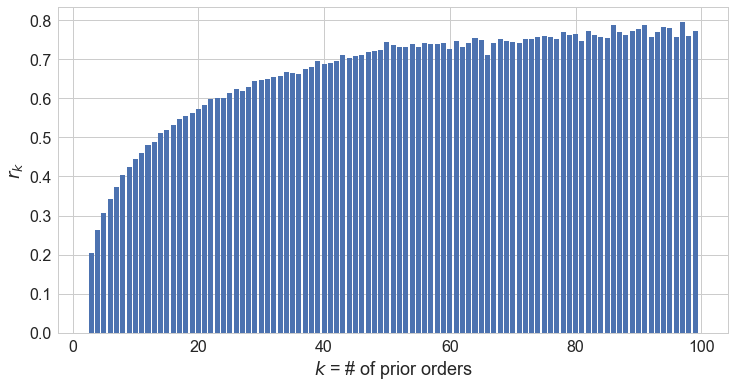

In [23]:
df = df_train.groupby('user_id').agg({'order_number': 'nunique', 'add_to_cart_order': 'count', 'reordered': 'sum'})
df = df.groupby('order_number').agg({'add_to_cart_order': 'sum', 'reordered': 'sum'})
df['reorder_rate'] = df.reordered / df.add_to_cart_order
plt.bar(df.index, df.reorder_rate)
plt.xlabel('$k$ = # of prior orders')
plt.ylabel('$r_{k}$')

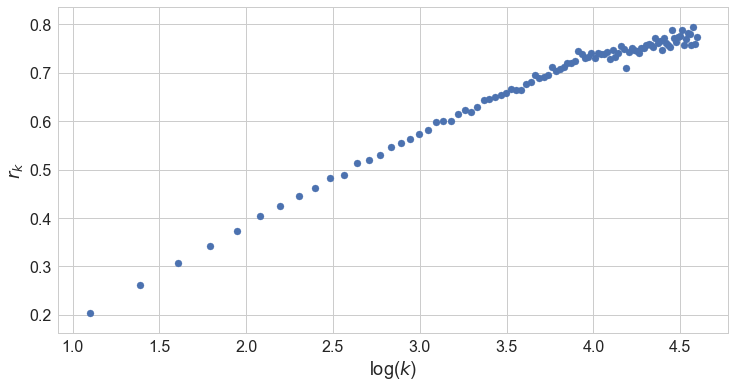

In [24]:
plt.scatter(np.log(df.index), df.reorder_rate)
plt.xlabel('log($k$)')
plt.ylabel('$r_{k}$')

Although there is some correlation between $r_{k}$ and $k$, this is not indicative of
reorder probability of a particular product in a particular order.

Consider the following example. Suppose there are only two users $u_{1}$ and $u_{2}$
both (hypothetically) ordering only product $p_{0}$ on every order.
Let $f_{pr}(u_{1}) = 2$ ($u_{1}$ having just started using the site) and
$f_{pr}(u_{2}) = 10$, then $r_{2} = 1/2$ and $r_{10} = 10/11$. Even if both users have
the same ordering behavior, it seems like $u_{2}$ has the higher probability of
reordering $p_{0}$.

## Bestsellers
--------
Let $A$ be the set of all products.

Let $g_{\textrm{buy}}: A \rightarrow \mathbb{N}$ where $g_{\textrm{buy}}(a)$
is the number of orders of product $a$.

Let $g_{\textrm{re}}: A \rightarrow \mathbb{N}$
where $g_{\textrm{re}}(a)$ is the number of reorders of product $a$.

Now, let
$$r_{a} = \frac{g_{\textrm{re}}(a)}{g_{\textrm{buy}}(a)}.$$
That is, $r_{a}$ is the ratio of the number reorders of product $a$
to the number of orders of product $a$. Before we proceed to simply
sorting $r_{a}$ on $A$, there are some factors to consider.

If we were to simply sort by $r_{a}$, due to how $r_{a}$ is calculated,
those with highest $r_{a}$ will be some niche products that only get
bought by small number of users who buy them often. Popular products
purchased by many users will have at least one order that isn't a
reorder per user, which will contribute to lower $r_{a}$ with $a$ being
purchased by "newer" users on the site.

In order to mitigate this problem, it may be a good idea to have
a certain threshold for the number of items sold for a product
in considering $r_{a}$, or any other "reorder probability" tied
to products. In order to do this, we use "bestsellers" list
of products.

Let $B_{q} \subseteq A$ be the set of all products that are bestsellers. This is defined as
those products above quantile $q \in I$ when $A$ is sorted by $g_{\textrm{buy}}(a)$. That is,
$$B_{q} = \{a \in A: g_{\textrm{buy}}(a) > x_{q}\}$$
where $x_{q}$ is defined as
$$P(g_{\textrm{buy}}(A) < x_{q}) > q.$$

In [41]:
def get_best_sellers_list(df, quantile):
    df_temp = df.groupby('product_id').agg({'order_id': 'count'}).rename(columns={'order_id': 'amount_sold'})
    return df_temp.loc[df_temp.amount_sold >= df_temp.amount_sold.quantile(quantile)].index.values

In [42]:
quantile = 0.8

In [43]:
# something that may be used later
bestsellers = get_best_sellers_list(df_train, quantile)

## Top 10 products with most orders, most reorders, and highest reorder rates

In [30]:
df = df_train.groupby('product_id').agg({'order_id': 'count', 'reordered': 'sum'}) \
    .rename(columns={'order_id': 'ordered'})
df['reordered_rate'] = df.reordered / df.ordered
df.reordered = df.reordered.astype(int)
df['product_name'] = df_products.loc[df.index, 'product_name']

In [31]:
# a helper function that gets used a lot
def get_bestsellers(df):
    if 'product_id' in df.columns:
        return df.loc[df.product_id.isin(bestsellers)]
    else:
        return df.loc[df.index.isin(bestsellers)]

In [32]:
print('{:.0f}% of all items sold: {:,.0f}'
      .format(quantile * 100, np.rint(df.ordered.sum() * quantile)))
print('items sold among the top {:.0f}% of most ordered products: {:,}'
      .format(np.rint((1 - quantile) * 100), get_bestsellers(df).ordered.sum()))

80% of all items sold: 16,513,593
items sold among the top 20% of most ordered products: 18,784,029


In [33]:
df = df.sort_values(by='ordered').copy()

In [34]:
# although not necessary, we define the variables here so as to avoid
# having long chains and a confusing piece of code
n_products = df.shape[0]
total_sold = df.ordered.sum()
bestsellers_range = np.arange(int(n_products * quantile), n_products)
top_quantile_range = np.arange((df.ordered.cumsum() < (total_sold * (1 - quantile))).sum(), n_products)

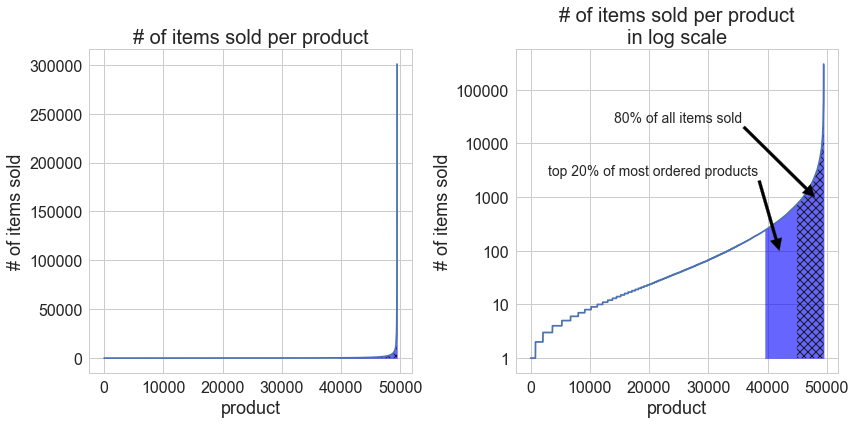

In [35]:
plt.subplot(1, 2, 1)
plt.plot(range(n_products), df.ordered)
plt.fill_between(bestsellers_range, df.iloc[bestsellers_range].ordered, color='blue', alpha=0.6)
plt.fill_between(top_quantile_range, df.iloc[top_quantile_range].ordered, hatch='XXX', alpha=0)
plt.title('# of items sold per product')
plt.xlabel('product')
plt.ylabel('# of items sold')

plt.subplot(1, 2, 2)
plt.plot(range(n_products), np.log10(df.ordered))
plt.fill_between(bestsellers_range, np.log10(df.iloc[bestsellers_range].ordered), color='blue', alpha=0.6)
plt.fill_between(top_quantile_range, np.log10(df.iloc[top_quantile_range].ordered), hatch='XXX', alpha=0)
plt.annotate('top {:.0f}% of most ordered products'.format(np.rint((1 - quantile) * 100)),
             xy=(42000, 2), xytext=(3000, 3.4), fontsize=14, arrowprops=dict(facecolor='black', width=3))
plt.annotate('{:.0f}% of all items sold'.format(np.rint(quantile * 100)),
             xy=(48000, 3), xytext=(14000, 4.4), fontsize=14, arrowprops=dict(facecolor='black', width=3))
plt.title('# of items sold per product\nin log scale')
plt.xlabel('product')
plt.ylabel('# of items sold')
plt.yticks(np.arange(6), 10 ** np.arange(6))

plt.tight_layout()

In [36]:
# above analysis shows that top 20% of most ordered products account for
# more than 80% of all items sold (indeed, they even account for more than 90%)
# we shall use this quantile as threshold in the coming sections

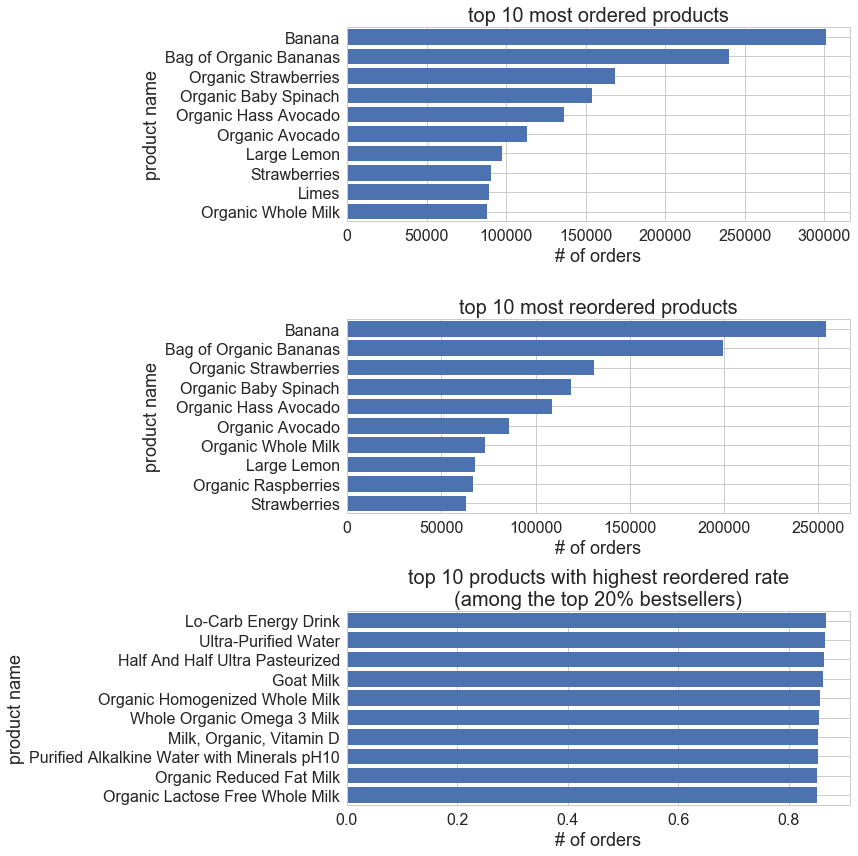

In [37]:
top_n = 10

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.barh(range(top_n), df.ordered[-top_n:])
plt.yticks(range(top_n), df.product_name[-top_n:])
plt.title('top {} most ordered products'.format(top_n))
plt.xlabel('# of orders')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2)

plt.subplot(3, 1, 2)
plt.barh(range(top_n), df.sort_values(by='reordered').reordered[-top_n:])
plt.yticks(range(top_n), df.sort_values(by='reordered').product_name[-top_n:])
plt.title('top {} most reordered products'.format(top_n))
plt.xlabel('# of orders')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2)

plt.subplot(3, 1, 3)
plt.barh(range(top_n), get_bestsellers(df).sort_values(by='reordered_rate').reordered_rate[-top_n:])
plt.yticks(range(top_n), get_bestsellers(df).sort_values(by='reordered_rate').product_name[-top_n:])
plt.title('top {} products with highest reordered rate\n(among the top {:.0f}% bestsellers)'\
          .format(top_n, np.round((1 - quantile) * 100)))
plt.xlabel('# of orders')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2)

plt.tight_layout()

In [38]:
# interestingly enough, everything in the top 10 of most ordered/reordered is edible
# moreover, most of them are produce
# on the other hand, most in the top 10 products with highest reordered rate are drinks

In [39]:
df_temp = get_bestsellers(df)

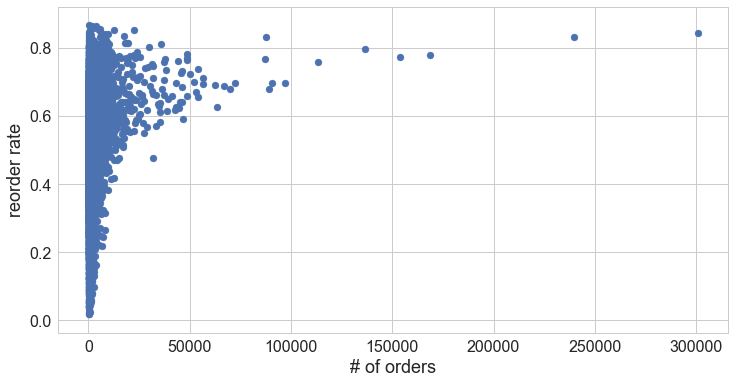

In [40]:
plt.scatter(df_temp.ordered, df_temp.reordered_rate)
plt.xlabel('# of orders')
plt.ylabel('reorder rate')

## Top 10 products with highest reorder probability per order

In [36]:
# given product x is ordered for the first time at some point in time,
# we calculate the average probabiliy that it will be ordered again
# in orders following the first ordering of x

In [37]:
df = df_train.loc[df_train.product_id.isin(bestsellers)]\
         .groupby(['user_id', 'product_id']).agg({'reordered': 'sum'})

In [38]:
df['first_order'] = df_train.loc[df_train.reordered == 0].set_index(['user_id', 'product_id']).order_number

In [39]:
df = df.reset_index(level=1)

In [40]:
df['number_of_orders'] = df_train.groupby('user_id').max().order_number
df['orders_after_first'] = df.number_of_orders - df.first_order

In [41]:
df_temp = df.reset_index().groupby('product_id').agg({'orders_after_first': 'sum', 'reordered': 'sum'})

In [42]:
df_temp['reorder_prob'] = (df_temp.reordered / df_temp.orders_after_first)

In [43]:
df_temp['product_name'] = df_products.product_name

In [44]:
df_temp = df_temp.sort_values(by='reorder_prob')

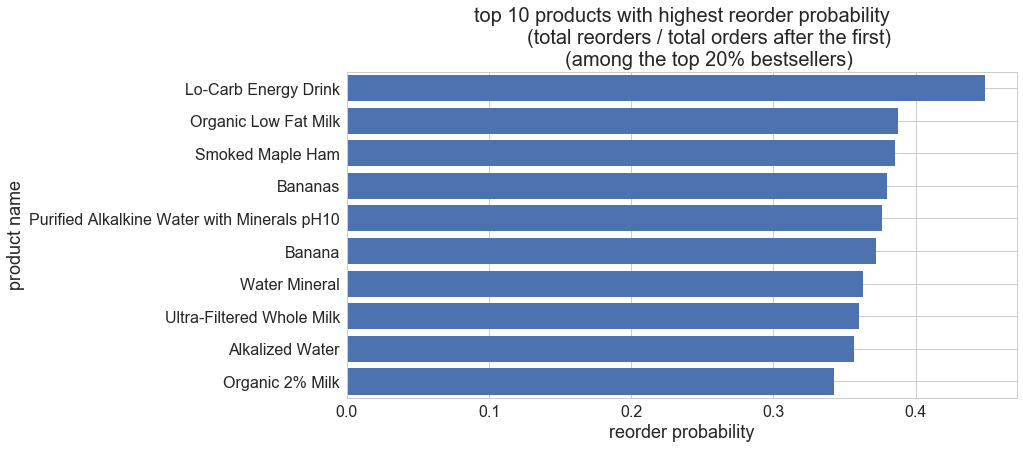

In [45]:
plt.barh(range(top_n), df_temp.reorder_prob[-top_n:])
plt.yticks(range(top_n), df_temp.product_name[-top_n:])
plt.title('top {} products with highest reorder probability\n\
          (total reorders / total orders after the first)\n\
          (among the top {:.0f}% bestsellers)'\
          .format(top_n, np.round((1 - quantile) * 100)))
plt.xlabel('reorder probability')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2);

In [46]:
df['reorder_prob'] = (df.reordered / df.orders_after_first)

In [47]:
df_temp = df.reset_index().groupby('product_id').agg({'reorder_prob': 'mean'}).sort_values(by='reorder_prob')
df_temp['product_name'] = df_products.product_name

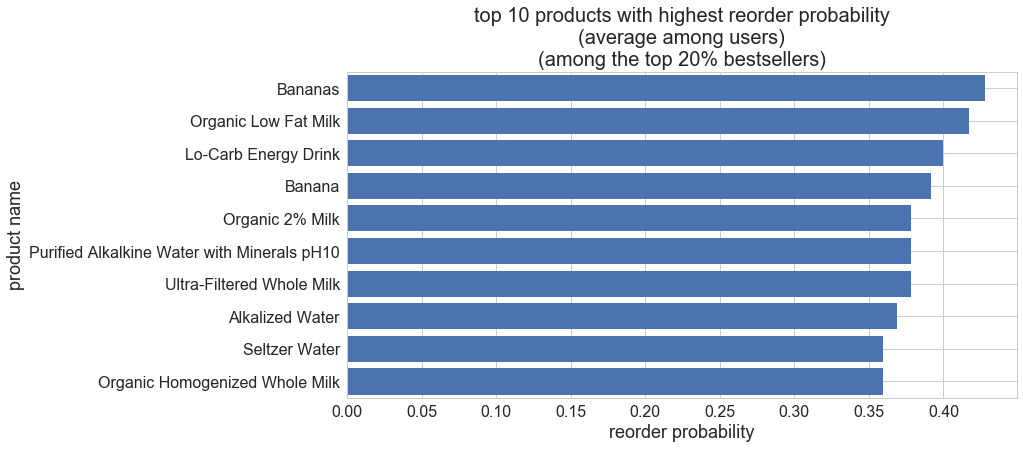

In [48]:
plt.barh(range(top_n), df_temp.reorder_prob[-top_n:])
plt.yticks(range(top_n), df_temp.product_name[-top_n:])
plt.title('top {} products with highest reorder probability\n(average among users)\n(among the top {:.0f}% bestsellers)'\
          .format(top_n, np.round((1 - quantile) * 100)))
plt.xlabel('reorder probability')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2);

In [49]:
# there doesn't seem to be too much of a difference between the two

## What time of the day do people order?

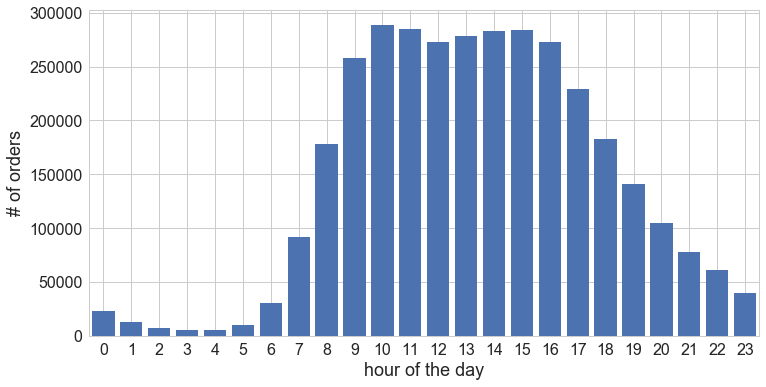

In [50]:
plt.hist(df_orders.order_hour_of_day,
         bins=np.arange(-1/2, 24 + 1/2),
         rwidth=0.8)
plt.xticks(range(24))
plt.xlim(-1/2, 24 - 1/2)
plt.xlabel('hour of the day')
plt.ylabel('# of orders')

In [51]:
# as expected, people order more during "normal" hours
# there is an unexpected dip around noon
# this could be interpreted as people not ordering during lunchtimes
# or that the dataset can be classified into different groups,
# perhaps one peaking at 10 and one peaking at 15

## How many items do people order per order?

In [52]:
df = df_train.groupby(['user_id', 'order_number']).agg({'add_to_cart_order': 'count'})\
    .rename(columns={'add_to_cart_order': 'number_of_items'})

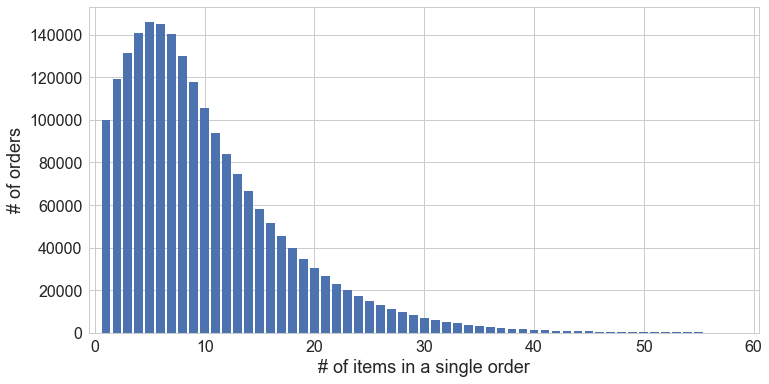

In [53]:
plt.hist(df.number_of_items,
         bins=np.arange(-1/2, df.number_of_items.max() + 1/2),
         rwidth=0.8);
plt.xlim(-1/2, 60 + 1/2)
plt.xlabel('# of items in a single order')
plt.ylabel('# of orders')

## What do people add to cart first?

In [54]:
df = get_bestsellers(df_train).groupby('product_id')\
         .agg({'order_id': 'count', 'add_to_cart_order': lambda x: (x == 1).sum()})\
         .rename(columns={'order_id': 'n_orders', 'add_to_cart_order': 'first_add'})

In [55]:
df['first_add_rate'] = df.first_add / df.n_orders

In [56]:
df['product_name'] = df_products.product_name

In [57]:
df = df.sort_values(by='first_add_rate')

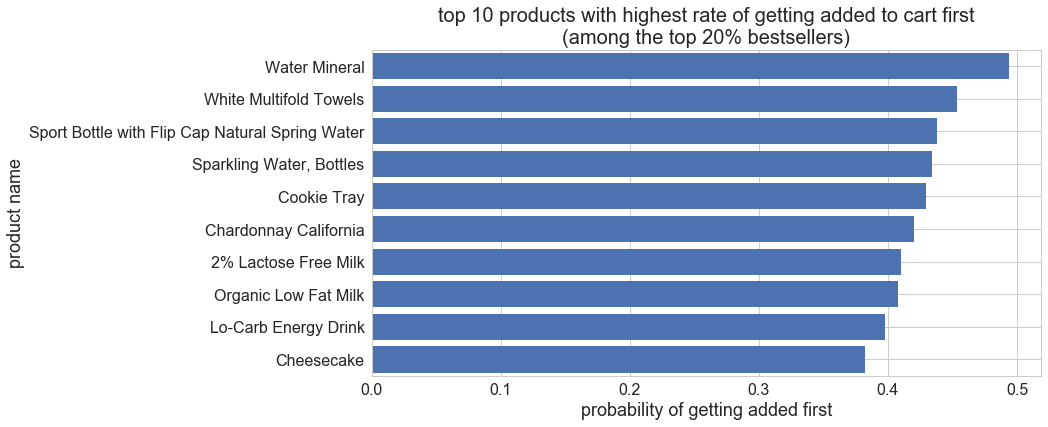

In [58]:
top_n = 10

plt.barh(range(top_n), df.first_add_rate[-top_n:])
plt.yticks(range(top_n), df.product_name[-top_n:])
plt.title('top {} products with highest rate of getting added to cart first\n(among the top {:.0f}% bestsellers)'\
          .format(top_n, np.round((1 - quantile) * 100)))
plt.xlabel('probability of getting added first')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2);

## What do people add to cart last?

In [59]:
%%time
df = df_train.groupby('order_id')\
         .agg({'add_to_cart_order': 'max', 'product_id': lambda x: x.iloc[-1]}).reset_index()\
         .groupby('product_id').agg({'order_id': 'count'}).rename(columns={'order_id': 'last_add'})

Wall time: 42.3 s


In [60]:
df['n_orders'] = df_train.groupby('product_id').agg({'order_id': 'count'}).order_id

In [61]:
df = get_bestsellers(df.reset_index()).set_index('product_id')

In [62]:
df['last_add_rate'] = df.last_add / df.n_orders

In [63]:
df['product_name'] = df_products.product_name

In [64]:
df = df.sort_values(by='last_add_rate')

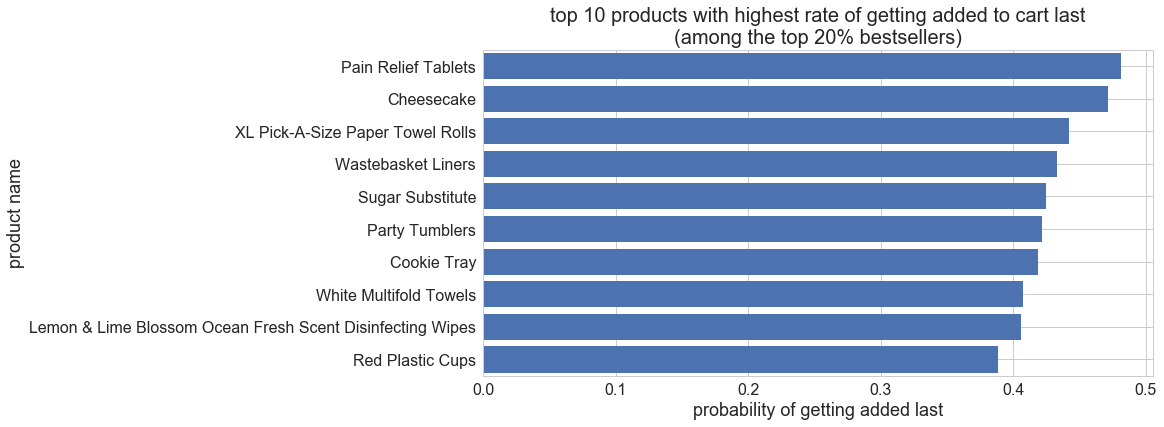

In [65]:
top_n = 10

plt.barh(range(top_n), df.last_add_rate[-top_n:])
plt.yticks(range(top_n), df.product_name[-top_n:])
plt.title('top {} products with highest rate of getting added to cart last\n(among the top {:.0f}% bestsellers)'\
          .format(top_n, np.round((1 - quantile) * 100)))
plt.xlabel('probability of getting added last')
plt.ylabel('product name')
plt.ylim(-1/2, top_n - 1/2);

## Days since prior vs reorder rate

In [66]:
df = df_train.groupby(['days_since_prior_order']).agg({'reordered': 'mean'})

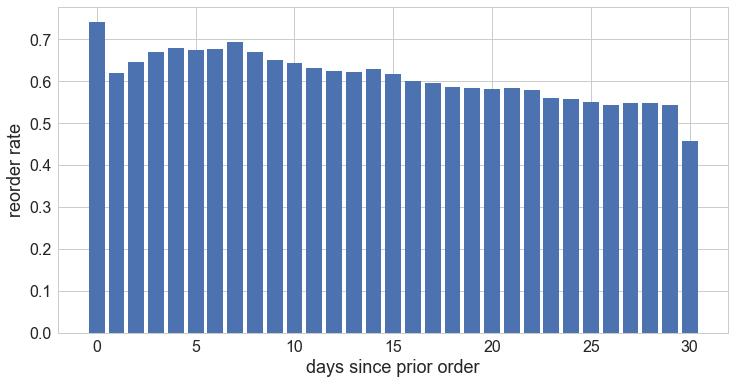

In [67]:
plt.bar(df.index, df.reordered)
plt.xlabel('days since prior order')
plt.ylabel('reorder rate')

In [68]:
# interestingly, orders placed on the same day have the highest reorder rate
# and there are actually quite a few of them
# also note that there is a slight bump on day 7 and perhaps day 14
# as for 30, there is a drastic decrease in reorder rates
# this again might suggest that 30 is just a placeholder number for 30 and over

## What are zero day reorders?

In [118]:
df = df_train[df_train.days_since_prior_order == 0].groupby('product_id').agg({'add_to_cart_order': 'count',
                                                                                      'reordered': 'mean'})

In [119]:
df['product_name'] = df_products.product_name

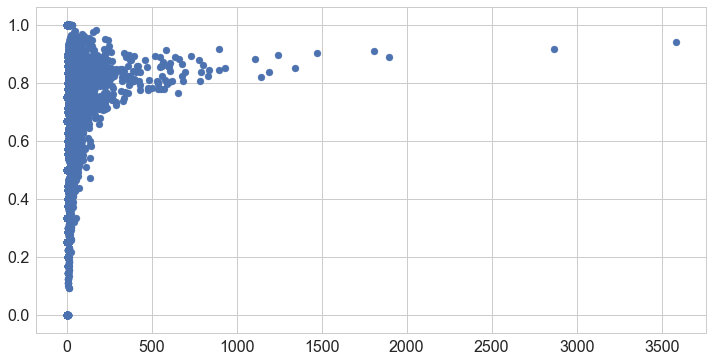

In [120]:
plt.scatter(df.add_to_cart_order, df.reordered)